In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib as pl
from natsort import natsort_keygen
%matplotlib inline

In [2]:
def read_survey_data(csv_results=None, csv_schema=None):
    """
    Return a pandas dataframe based.

        Parameters:
                - csv_results - contains the original survey results from stack overflow in a csv-datafile
                - csv_schema - contains the original survey schema from stack overflow in a csv-datafile

        Returns:
                - data - pandas dataframe of the survey results
                - schema - pandas dataframe of the survey schema
    """
    # check if survey file exists
    if csv_results.is_file():
        data = pd.read_csv(csv_results)
    else:
        print('ERROR: No csv-datafile available!\n')
        sys.exit(-9)

    # check if survey file exists
    if csv_schema.is_file():
        schema = pd.read_csv(csv_schema)
    else:
        print('ERROR: No csv-datafile available!\n')
        sys.exit(-9)

    return data, schema

In [3]:
csv_results = pl.Path('data/survey_results_public.csv')
csv_schema = pl.Path('data/survey_results_schema.csv')

# call of prior defined function
data, schema = read_survey_data(csv_results, csv_schema)

# Question 1:
## *Is there a noticeable home office spread among professional generations?*

First of all, I look at some entries of the dataset to get an idea of what I am working with.

Since I am particularly interested in the spread between the experience levels of the developers, I need to drop all answers that are missing the *'YearsCodePro'*  entry. We can not really imply or dangle a missing value, so I need to drop the rows completely.

In [4]:
# filter data for columns of interest
df_1 = data[['MainBranch', 'Employment', 'RemoteWork', 'YearsCodePro', 'Age']]

# Drop rows with missing professional years
df_1 = df_1.dropna(subset=['YearsCodePro'], axis=0)
df_1.head()

,MainBranch,Employment,RemoteWork,YearsCodePro,Age
2,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",5,25-34 years old
3,I am a developer by profession,"Employed, full-time",Fully remote,17,35-44 years old
4,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",3,25-34 years old
8,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",6,25-34 years old
9,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Fully remote,30,45-54 years old


Finally I can get the number of total available answers. 

In [24]:
# After filtering and droping a total number of X answers remains
# Print this amount
total_entries = df_1.shape[0]
print(f'\nThe total number of answer is: {total_entries}')
print(100 * '_' + '\n')


The total number of answer is: 51833
____________________________________________________________________________________________________



Below I plot different question answers and their distribution through the possible answers.
One can draw a few conclusion of this already, such as the survey took nearly only professional developers.

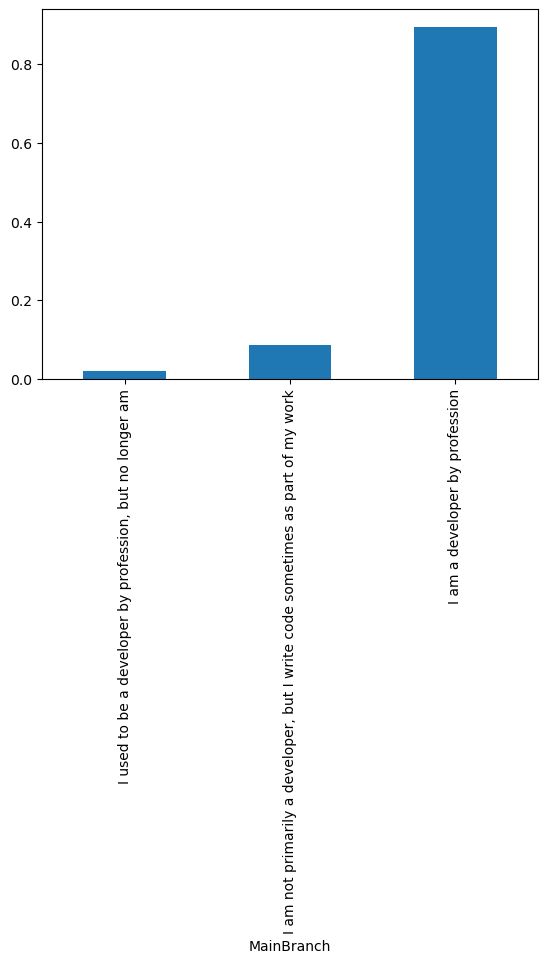

In [6]:
# Have a look at different entires and their distributions
mainbranch = df_1['MainBranch'].value_counts().sort_values()
(mainbranch/total_entries).plot(kind='bar', legend=None)
plt.show()

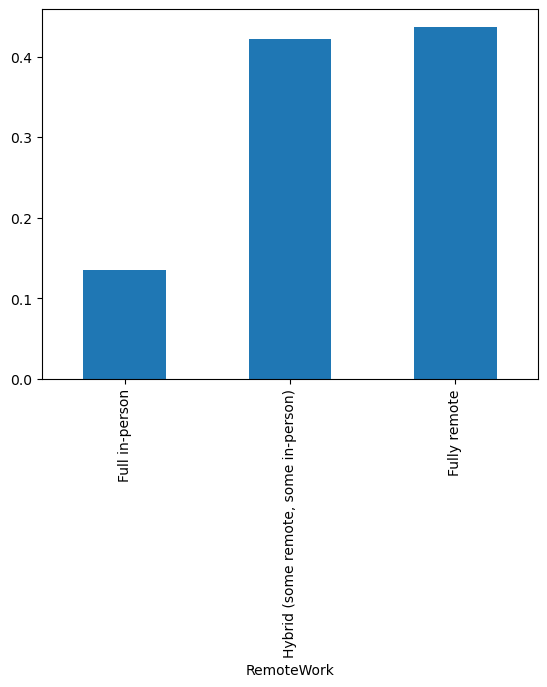

In [7]:
remotework = df_1['RemoteWork'].value_counts().sort_values()
(remotework/total_entries).plot(kind='bar', legend=None)
plt.show()

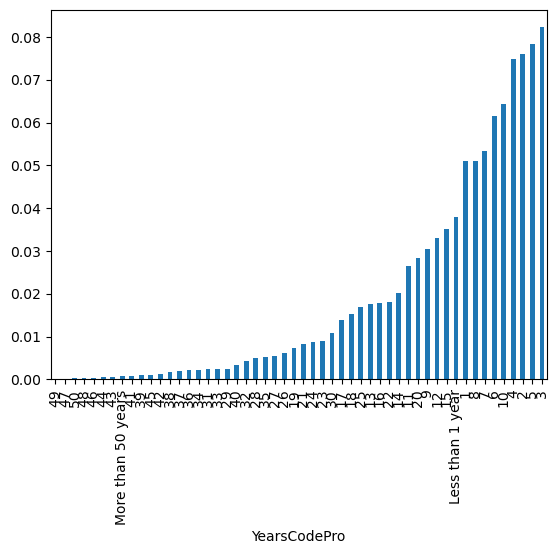

In [8]:
yearscodepro = df_1['YearsCodePro'].value_counts().sort_values()
(yearscodepro/total_entries).plot(kind='bar', legend=None)
plt.show()

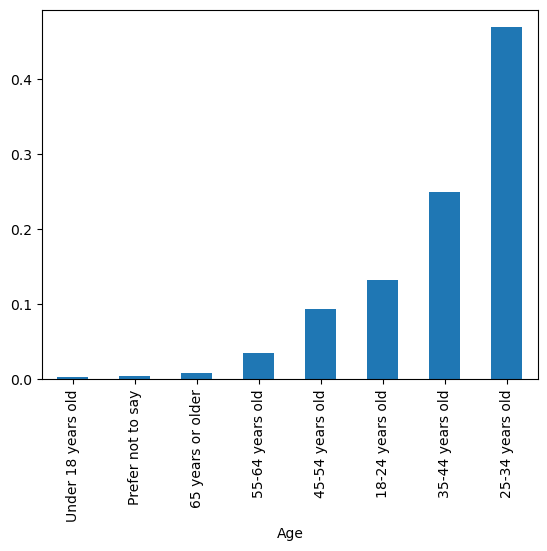

In [9]:
age = df_1['Age'].value_counts().sort_values()
(age/total_entries).plot(kind='bar', legend=None)
plt.show()

In [10]:
# Copy the original filtered dataframe to keep the unaltered one in memory
df_1_orig = df_1.copy()

In the following the proportion of the different work situations per experience level is looked at.

**remotework.keys()** defines the possible situations: **fully remote, hybrid, full in-person**

For each year of work experience *'YearsCodePro'*, the number per possible key is counted and written in new data frame **ycp_main**
In the final step each entry is divided by the sum of the row. 

This fraction represents the portion of work situation per experience level.

In [11]:
# Create empty dataframe
ycp_main = pd.DataFrame()
key_list = [] #empty key list
# loop over the possible key entries
for key in remotework.keys():
    print(key)
    tmp = df_1_orig.groupby('RemoteWork').get_group(key)['YearsCodePro'].value_counts().sort_index(key=natsort_keygen())
    tmp = tmp.rename(key)
    tmp = tmp.fillna(0)
    # store resulting count in the empty dataframe, concat if already existing data is present
    ycp_main = pd.concat([ycp_main, tmp], axis=1)
    key_list.append(key)

# fill missing values by zero since NaN represents no answer, the count can be represented as zero
ycp_main = ycp_main.fillna(0)
ycp_main = ycp_main.sort_index(key=natsort_keygen()) 
ycp_main["sum"] = ycp_main.sum(axis=1) # sum each row and add column to dataframe
print(100 * '_' + '\n')

Full in-person
Hybrid (some remote, some in-person)
Fully remote
____________________________________________________________________________________________________



After the summation of each row in the data frame **ycp_main**, **ycp_1** is initialized by the first three columns of **ycp_main**.

Each row of **ycp_1**  is divided by the earlier defined sum of the corresponding row to get the portion of work situation per *'YearsCodePro'*.

I could have just divided the rows in **ycp_main** and drop the final *sum* column, but I wanted different sorted data sets and thus initialized **ycp_1** and **ycp_2**.

**ycp_1** is sorted in ascending work experience, whereas **ycp_2** is sorted in descending **fully remote** portion to highlight the groups with most **fully remote** workers.

In [12]:
# create new dataframe, where first three columns are divided by the sum of the row
ycp_1 = ycp_main.loc[:, key_list[0]:key_list[-1]].div(ycp_main["sum"], axis=0)
# highlight the home office entries by sorting with respect to the fully remote column from high to low
ycp_2 = ycp_1.sort_values(key_list[-1], ascending=False)

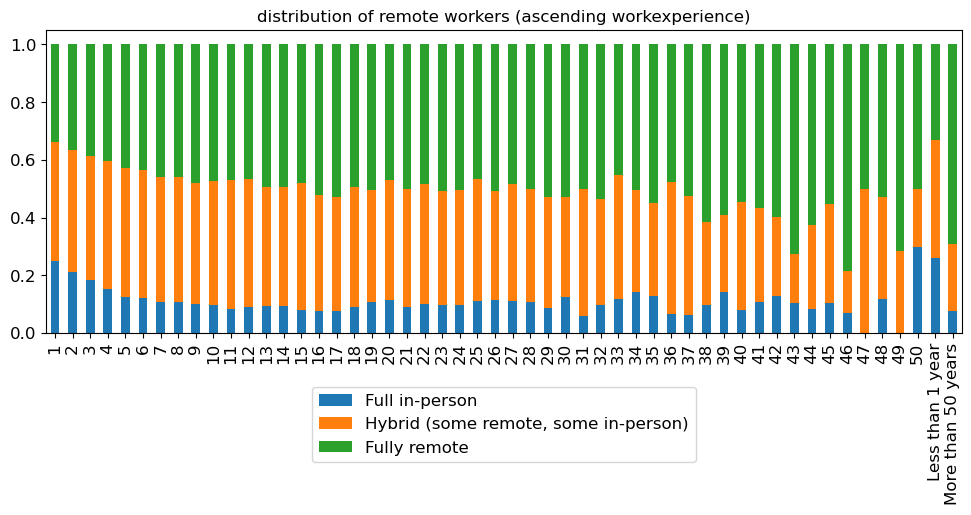

In [13]:
# plot the original dataframe sorted by work experience
plot1 = ycp_1.plot(y=key_list, kind="bar", figsize=(30/2.54, 10/2.54), fontsize=12, stacked=True)
plot1.set_title("distribution of remote workers (ascending workexperience)", fontsize=12)
plot1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12)
plot1.get_figure().savefig('remoteworkers_experience.png', format='png',  dpi=600, bbox_inches='tight')

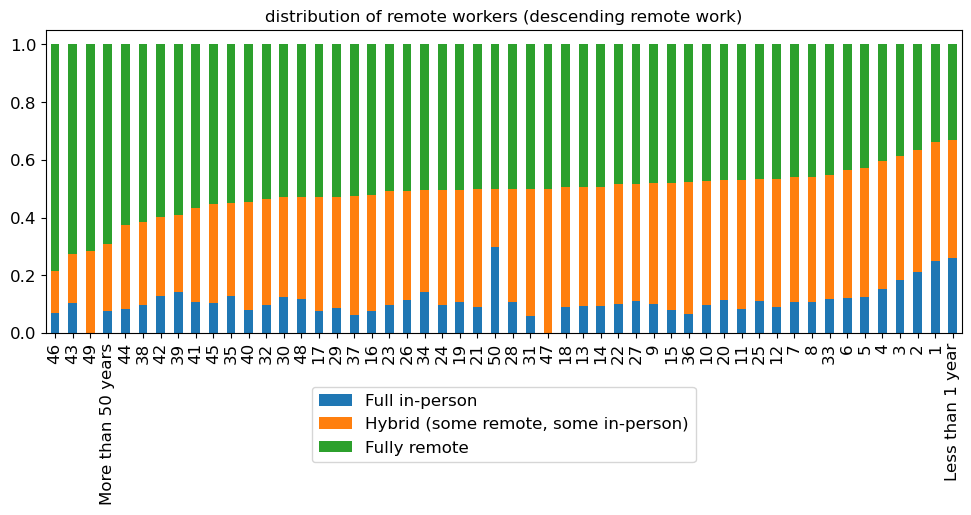

In [14]:
# plot the same results but now sorted after the highest portion of home office (fully remote) workers
plot2 = ycp_2.plot(y=key_list, kind="bar", figsize=(30/2.54, 10/2.54), fontsize=12, stacked=True)
plot2.set_title("distribution of remote workers (descending remote work)", fontsize=12)
plot2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=12)
plot2.get_figure().savefig('remoteworkers_descending.png', format='png', dpi=600, bbox_inches='tight')

# Question 2:
## *Opinions of age groups on blockchain, cryptocurrencies and decentralization?*

To tackle the second question, I initialized a new data frame based on the original data set and filtered the groups of interest, namely *'Age'* and *'Blockchain'*. 

Since I was interested in the occurrence per answer not the answers itself, I initialized dummy variables for the possible answers regarding the *'Blockchain'* column. The final data frame do work with consists of the *'Age'* column and the dummy data for the *'Blockchain'* columns.

Similar to question 1, I can not dangle missing *'Age'* entries, since there is no knowledge about age to go with I dropped the rows, where *'Age'* is missing. 

In [15]:
# define base dataset from the original one for question two and drop NaN
df_2 = data[['Age', 'Blockchain']]
df_2 = df_2.dropna(axis=0)

# Possible answers for their opinion on blockchain technologies
possible_vals = ['Indifferent', 'Unfavorable', 'Unsure', 'Very favorable', 'Very unfavorable']

# get categorical dummy values and merge them in dataset
df_bc = pd.get_dummies(data['Blockchain'], drop_first=True, dummy_na=False)

df_2 = pd.concat([df_2.drop('Blockchain', axis=1), df_bc], axis=1)
df_2 = df_2.dropna(subset=['Age'], axis=0)

During analysis, I faced the problem that the total number of different opinions did not match the total number of answers in the data frame. There I noticed, that there existed rows where no opinion on blockchain technologies where given. Since these rows also bear no information for this question, they need to be dropped, too.

In [16]:
# Filter rows with all False  == no answers
df_2 = df_2[df_2.loc[:, possible_vals[0]:possible_vals[-1]].any(axis=1)]

In [27]:
# count total answer per age group and store in variable
age_groups = df_2['Age'].value_counts()
age_groups = age_groups.sort_index()
print(age_groups)
print(100 * '_' + '\n')

Age
18-24 years old       12427
25-34 years old       22112
35-44 years old       11389
45-54 years old        4406
55-64 years old        1681
65 years or older       500
Prefer not to say       431
Under 18 years old     2931
Name: count, dtype: int64
____________________________________________________________________________________________________



The data frame is grouped by the different *'Age'* values and summed per group. This newly initialized data frame is then sorted to match the earlier gathered information of total number of answers per age group **age_groups**.

Finally, the portion per answer and age group is computed, where in the end the deviation from the corresponding mean

In [18]:
# sum all answers per age group and sort them
df_2_grouped = df_2.groupby('Age').sum()
df_2_grouped = df_2_grouped.sort_values(by='Age', key=natsort_keygen())
# to get the portion of each age group we divide by the total number of answers per age group
frac_df_2 = df_2_grouped.div(age_groups, axis=0)
# get the distance between the fraction of answer per age group from the mean number of answers per possible answer
# by this we can plot the deviation from the mean later
distance = frac_df_2 - frac_df_2.mean()

The plot below gives an idea about the deviation per possible answer.

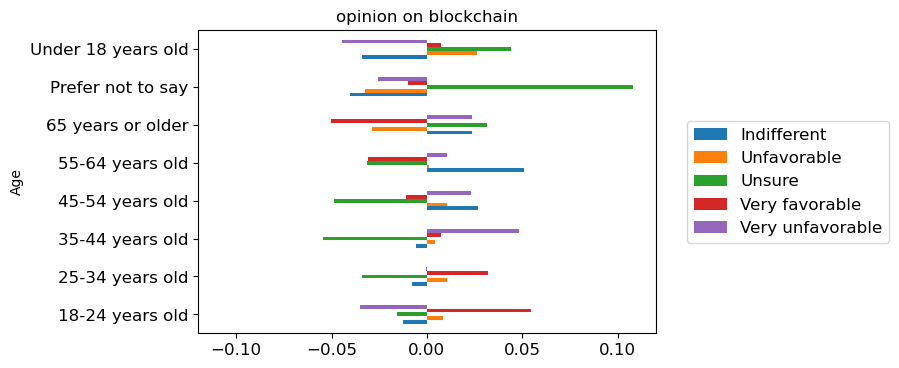

In [19]:
# plot the deviation of the possible answers per age group
plot3 = distance.plot.barh(y=possible_vals, figsize=(15/2.54, 10/2.54), fontsize=12, align='center')
plot3.set_title("opinion on blockchain", fontsize=12)
plot3.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
plot3.set_xlim(-0.12, 0.12)
plot3.get_figure().savefig('blockchain2.png', format='png', dpi=600, bbox_inches='tight')

# Question 3:
## *Which groups tend to share knowledge or answer more questions?*

Similar to the other questions, the original data is filtered and missing values are dropped. Again, since there is no information to gain similar information missing *'YearsCodePro'* are dropped from the dataset.

This time, the *'TimeAnswering'* is of interest, and thus the possible occurrences are counted.

In the **df_3_keys** these possible answers are stored and printed.

In [20]:
# get filtered dataset for final question
df_3 = data[['YearsCodePro', 'TimeAnswering']]
df_3 = df_3.dropna(axis=0)

# group the dataset by the time spent for answeres and count the occurence
df_3_grouped = df_3.groupby(['TimeAnswering']).value_counts().sort_index()

# df_3_keys - possible answer of the answering times (15-30 minutes, ....)
df_3_keys = list(df_3['TimeAnswering'].value_counts().keys())
print('Data contains possible answers:\n')
for answer in df_3_keys:
    print(answer)

print(100 * '_' + '\n')

Data contains possible answers:

15-30 minutes a day
30-60 minutes a day
Less than 15 minutes a day
60-120 minutes a day
Over 120 minutes a day
____________________________________________________________________________________________________



Initialize an empty **6x6** data frame. 

Possible answers serve as row names, to simplify analysis experience levels are packed into decades and serve as column names. 

This empty data frame will then be filled with information.

In [21]:
# create an empty 5x6 dataframe, where we can store the portions of row to column per answer
survey_res = pd.DataFrame(columns=['Less than 10 years', '10 - 20 years',
                                   '20 - 30 years', '30 - 40 years',
                                   '40 - 50 years', 'More than 50 years'], index=[df_3_keys])
survey_res

,Less than 10 years,10 - 20 years,20 - 30 years,30 - 40 years,40 - 50 years,More than 50 years
15-30 minutes a day,NaN,NaN,NaN,NaN,NaN,NaN
30-60 minutes a day,NaN,NaN,NaN,NaN,NaN,NaN
Less than 15 minutes a day,NaN,NaN,NaN,NaN,NaN,NaN
60-120 minutes a day,NaN,NaN,NaN,NaN,NaN,NaN
Over 120 minutes a day,NaN,NaN,NaN,NaN,NaN,NaN


To fill the empty **survey_res** data frame a loop over each possible answer is initialized.

For each possible decade group (e.g., *'Less than 10 years'* or *'10 - 20 years'*), the number of answers is counted and added. This is achieved by the **if-block**, where each possible *'YearsCodePro'* entry is grouped in the corresponding experience level.

In the final step, each added row of **survey_res** is normalized by the sum of the row, so each row adds up to 1.

In [22]:
# loop over the possible answers (there exist 5 possible answers)
for k_idx, key in enumerate(df_3_keys):
    # create empty dummy sums to count the answers per age range
    # to have a better overview of data age is grouped in ranges of 10 years
    lt_ten = 0 # less than 10 years
    ten_to_twenty = 0 # 10 to 20 years
    twenty_to_thirty = 0 # 20 to 30 years
    thirty_to_forty = 0 # 30 to 40 years
    forty_to_fifty = 0 # 40 to 50 years
    mt_fifty = 0 # more than 50 years
    yearspro = 0 # dummy key for answer

    # get temporary data for key
    df_3_tmp = df_3_grouped[key]

    # loop over all entries per specific key
    indices_tmp = list(df_3_tmp.keys())
    for entry_idx, entry in enumerate(df_3_tmp):

        # dummy answers to compare all as integer
        if df_3_tmp.index[entry_idx] == 'Less than 1 year':
            yearspro = 0
        elif df_3_tmp.index[entry_idx] == 'More than 50 years':
            yearspro = 50
        else:
            yearspro = int(df_3_tmp.index[entry_idx])

        # select group and add the number of answers to that group
        if yearspro < 10:
            lt_ten += entry
        elif (yearspro >= 10 and yearspro < 20):
                ten_to_twenty += entry

        elif ( yearspro >= 20 and yearspro < 30):
                twenty_to_thirty += entry

        elif (yearspro >= 30 and yearspro < 40):
                thirty_to_forty += entry

        elif (yearspro >= 40 and yearspro < 50):
                forty_to_fifty += entry
        else:
            mt_fifty += mt_fifty

    # normalize all data with respect to the total amount of answers
    lt_ten /= df_3_tmp.sum()
    ten_to_twenty /= df_3_tmp.sum()
    twenty_to_thirty /= df_3_tmp.sum()
    thirty_to_forty /= df_3_tmp.sum()
    forty_to_fifty /= df_3_tmp.sum()
    mt_fifty /= df_3_tmp.sum()
    yearspro /= df_3_tmp.sum()

    survey_res.loc[key, 'Less than 10 years'] = lt_ten
    survey_res.loc[key, '10 - 20 years'] = ten_to_twenty
    survey_res.loc[key, '20 - 30 years'] = twenty_to_thirty
    survey_res.loc[key, '30 - 40 years'] = thirty_to_forty
    survey_res.loc[key, '40 - 50 years'] = forty_to_fifty
    survey_res.loc[key, 'More than 50 years'] = mt_fifty

survey_res.sort_index()

,Less than 10 years,10 - 20 years,20 - 30 years,30 - 40 years,40 - 50 years,More than 50 years
15-30 minutes a day,0.654224,0.227752,0.085114,0.027139,0.00568,0.0
30-60 minutes a day,0.592593,0.278025,0.102321,0.02163,0.00484,0.0
60-120 minutes a day,0.521292,0.320335,0.12488,0.029187,0.003828,0.0
Less than 15 minutes a day,0.691281,0.20412,0.076309,0.023212,0.004497,0.0
Over 120 minutes a day,0.531673,0.299644,0.129537,0.031317,0.007829,0.0


**plot4** gives an idea about the distribution of answer per experience level.

Since each bar adds up to 1, it is easy to distinguish with the first look, which experience level shares the majority per bar.

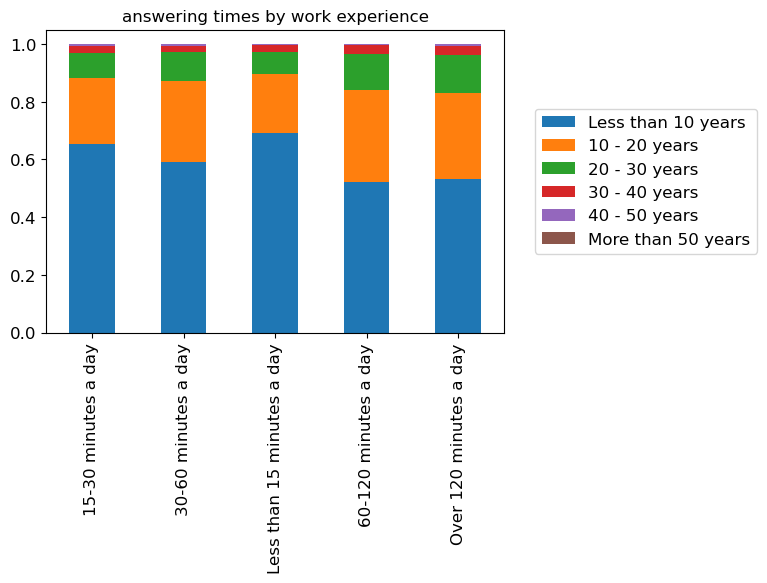

In [23]:
# create a stacked plot of the answers. each bar shall sum up to 1!
plot4 = survey_res.plot(kind="bar", figsize=(15/2.54, 10/2.54),
                            fontsize=12, stacked=True)
plot4.set_xticklabels(df_3_keys)
plot4.set_title("answering times by work experience")
plot4.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)

plot4.get_figure().savefig('answer_times_stacked.png', format='png', dpi=600, bbox_inches='tight')